In [1]:
import train as proteo_train
import os
import torch
import torch.nn.functional as F
import torch_geometric
from proteo.datasets.ftd import FTDDataset, reverse_log_transform
import torch.nn.functional as F
import pytorch_lightning as pl
from scipy.stats import zscore
from proteo.checkpoint_analysis import full_load_and_run_and_convert, process_checkpoints
%load_ext autoreload
%autoreload 2

weight_decay=0 wandb_api_key_path='wandb_api_key.txt' sex_specific_adj_choices=[True, False] lr=0.001327115054804925 q_gpu=True act_choices=['relu', 'tanh', 'sigmoid', 'elu'] l1_lambda_max=0.1 gat_v4_fc_dim=[[64, 128, 128, 32], [128, 256, 256, 64], [256, 512, 512, 128]] gcn_num_layers=[2, 3, 4] seed=21988 epochs=1000 ray_tmp_dir='/scratch/lcornelis/tmp' master_nodes=['sex', 'mutation', 'age'] cpu_per_worker=1 ray_results_dir='/scratch/lcornelis/outputs/ray_results' gat_v4_heads=[[2, 3], [2, 2], [4, 4]] reduction_factor=6 modality='csf' dropout=0.2 l1_lambda_min=1e-05 wandb_tmp_dir='/tmp' sex_specific_adj=False sync_batchnorm=False lr_scheduler_choices=['LambdaLR', 'ReduceLROnPlateau', 'StepLR', 'CosineAnnealingLR'] gpu_per_worker=1 checkpoint_every_n_epochs_train=1 precision='32-true' num_to_keep=2 dataset_name='ftd' accumulate_grad_batches=1 gat_v4_hidden_channels=[[8, 16], [32, 64], [64, 128]] gat_heads=[1, 2, 4, 8] y_val='nfl' log_every_n_steps=10 lr_min=1e-06 batch_size_choices=[8,

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([13, 1])
Normalized Val MSE: tensor(0.1094, grad_fn=<MeanBackward0>)
Normalized Val MSE2: tensor(0.1094)
Normalized train MSE: 0.4501226544380188
Original Units Train MSE: tensor(175.4382)
Original Units Train RMSE: tensor(13.2453)
Original Units Val MSE: tensor(42.6507, grad_fn=<MseLossBackward0>)
Original Units Val RMSE: tensor(6.5308, grad_fn=<SqrtBackward0>)
Val Z scores: [ 1.5139713  -1.2839146  -3.9388497  -0.850048    0.34457085 -1.3382287
  0.3593261  -0.1262178   0.5280581   0.7314485  -0.00721592 -1.8356981
  0.7838596   0.3405099  -1.0001706  -0.20036756  0.2238423   0.37705263
  0.04471414  0.0555602   0.0769585   0.70365316  0.5386059   1.7444937
  0.3171107  -1.9776137  -0.58179045 -1.1996549   0.34925976  0.39341828
  0.2533018   0.39445424  0.2381105  -0.4744843   0.5276852  -0.47527552
  0.6851357  -0.06952794  0.47538888  0.0455504   1.6382879   0.95763904
  0.35689905  0.50712174 -0.14692934]


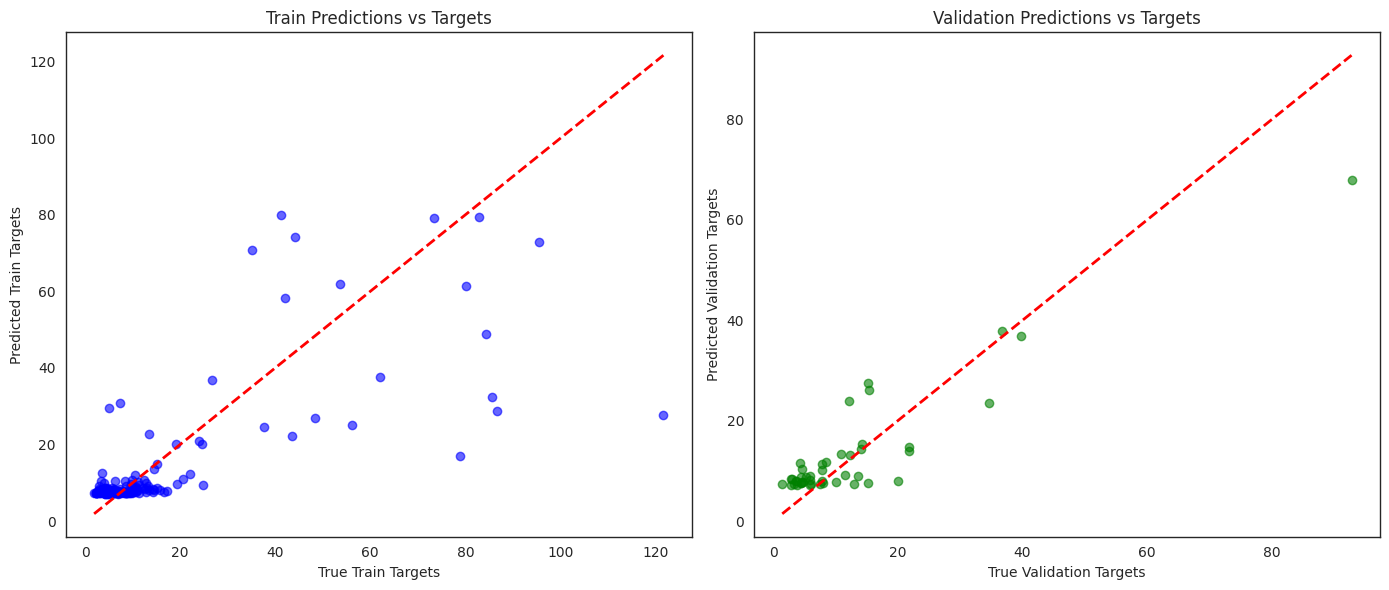

sex_choices=[['M', 'F']] gcn_num_layers=[2, 3, 4] dropout=0.2 wgcna_minModuleSize=10 num_workers=16 y_val='nfl' devices=[0, 1, 2, 3, 4, 5, 6, 7] grace_period=30 cpu_per_worker=1 gat-v4={'hidden_channels': [32, 64], 'heads': [2, 2], 'use_layer_norm': True, 'which_layer': ['layer1', 'layer2', 'layer3', 'sex', 'mutation'], 'fc_dim': [128, 256, 256, 64], 'fc_dropout': 0.2, 'fc_act': 'tanh', 'weight_initializer': 'kaiming', 'num_layers': None, 'channel_list': None, 'norm': None, 'plain_last': None} accumulate_grad_batches=1 modality_choices=['csf'] nodes_count=1 mlp_norms=['batch_norm', 'layer_norm'] wandb_tmp_dir='/tmp' weight_decay=0 gcn={'num_layers': 3, 'hidden_channels': 32} pin_memory=True ray_tmp_dir='/scratch/lcornelis/tmp' wgcna_mergeCutHeight=0.25 output_dir='/scratch/lcornelis/outputs' lr_scheduler_choices=['LambdaLR', 'ReduceLROnPlateau', 'StepLR', 'CosineAnnealingLR'] l1_lambda_max=0.1 gat_num_layers=[2, 4, 6, 12] num_samples=2000 model_grid_search=['gat-v4'] ray_results_dir='/

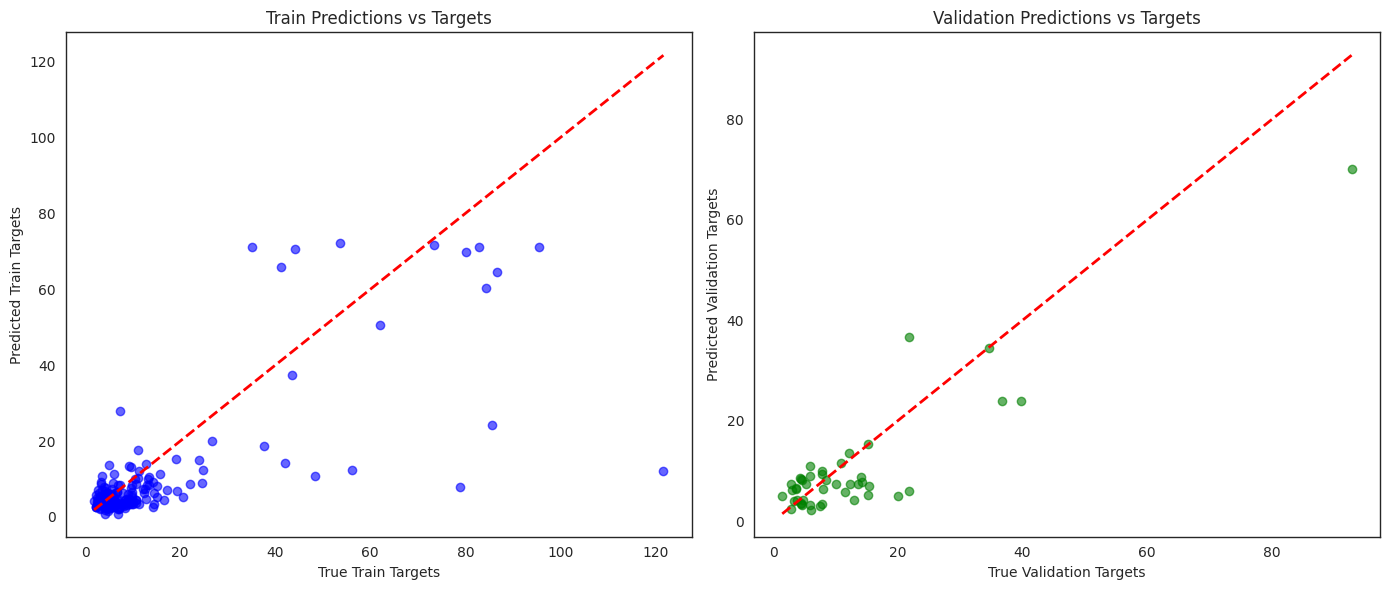

l1_lambda_max=0.1 checkpoint_every_n_epochs_train=1 mlp={'channel_list': [7261, 32, 64, 128, 1], 'norm': 'batch_norm', 'plain_last': True} raw_file_name='ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv' dataset_name='ftd' use_progress_bar=True modality_choices=['csf'] epochs=1000 sex_specific_adj_choices=[True, False] wgcna_minModuleSize=10 precision='32-true' ray_results_dir='/scratch/lcornelis/outputs/ray_results' batch_size_choices=[8, 16, 32, 50] y_val_choices=['nfl'] mlp_channel_lists=[[7261, 1], [7261, 1028, 1], [7261, 128, 64, 1], [7261, 1028, 128, 1], [7261, 1028, 256, 64, 1], [7261, 1028, 512, 128, 1], [7261, 1028, 256, 128, 64, 1]] num_to_keep=2 gat={'num_layers': 2, 'hidden_channels': 256, 'heads': 4, 'v2': True} weight_decay=0 ray_tmp_dir='/scratch/lcornelis/tmp' num_samples=2000 act_choices=['relu', 'tanh', 'sigmoid', 'elu'] log_every_n_steps=10 checkpoint_dir='/scratch/lcornelis/outputs/checkpoints' model='gat-v4' adj_thresh=0.5 gat_num_layers=[2, 4, 6, 12] project

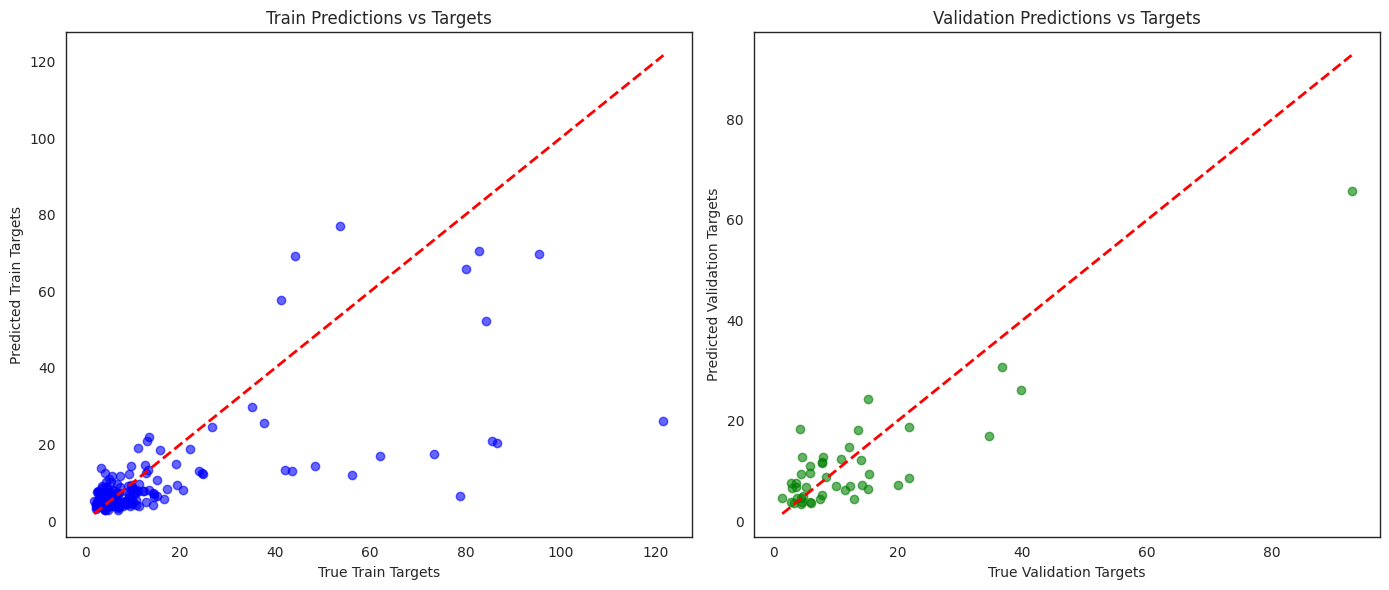

In [3]:
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'

csf_all_no_log_mean= 14.254120261931426
csf_all_no_log_std = 19.742249678382503

# Without Age:
# Without Sex Specific Adj
model_1_no_age_no_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-04_18-54-36/model=gat-v4,seed=21988_1567_act=elu,adj_thresh=0.3500,batch_size=16,dropout=0.2000,l1_lambda=0.0000,lr=0.0013,lr_scheduler=Cosine_2024-11-05_15-24-32/checkpoint_000105"
model_2_no_age_no_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-04_18-54-36/model=gat-v4,seed=42389_2701_act=relu,adj_thresh=0.9000,batch_size=32,dropout=0.2000,l1_lambda=0.0004,lr=0.0029,lr_scheduler=Lambd_2024-11-06_07-56-01/checkpoint_000022"
model_3_no_age_no_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-04_18-54-36/model=gat-v4,seed=49046_2947_act=sigmoid,adj_thresh=0.5000,batch_size=16,dropout=0.1000,l1_lambda=0.0004,lr=0.0018,lr_scheduler=Re_2024-11-06_11-46-42/checkpoint_000026"
outputs = full_load_and_run_and_convert(model_1_no_age_no_sex, device, csf_all_no_log_mean, csf_all_no_log_std)
outputs = full_load_and_run_and_convert(model_2_no_age_no_sex, device, csf_all_no_log_mean, csf_all_no_log_std)
outputs = full_load_and_run_and_convert(model_3_no_age_no_sex, device, csf_all_no_log_mean, csf_all_no_log_std)


act='relu' gat-v4={'hidden_channels': [8, 16], 'heads': [2, 3], 'use_layer_norm': True, 'which_layer': ['layer1', 'layer2', 'layer3', 'sex', 'mutation'], 'fc_dim': [256, 512, 512, 128], 'fc_dropout': 0.2, 'fc_act': 'tanh', 'weight_initializer': 'orthogonal', 'num_layers': None, 'channel_list': None, 'norm': None, 'plain_last': None} master_nodes=['sex', 'mutation', 'age'] num_workers=16 sex_choices=[['M', 'F']] batch_size_choices=[8, 16, 32, 50] gat_v4_heads=[[2, 3], [2, 2], [4, 4]] raw_file_name='ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv' sync_batchnorm=False wgcna_minModuleSize=10 gcn_num_layers=[2, 3, 4] weight_decay=0 nodes_count=1 wandb_tmp_dir='/tmp' dropout_choices=[0.1, 0.2, 0.5] checkpoint_dir='/scratch/lcornelis/outputs/checkpoints' mlp_channel_lists=[[7261, 1], [7261, 1028, 1], [7261, 128, 64, 1], [7261, 1028, 128, 1], [7261, 1028, 256, 64, 1], [7261, 1028, 512, 128, 1], [7261, 1028, 256, 128, 64, 1]] num_to_keep=2 sex_specific_adj=True gat={'num_layers': 2, 'hi

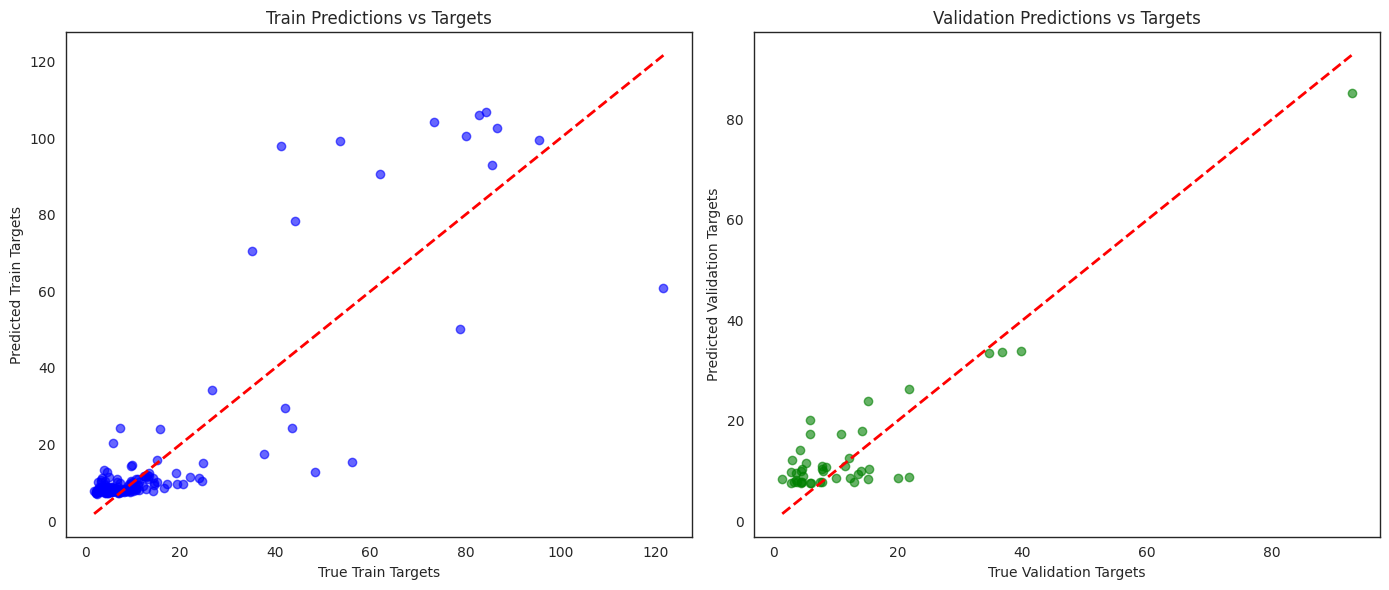

q_gpu=True raw_file_name='ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv' gat_v4_fc_dim=[[64, 128, 128, 32], [128, 256, 256, 64], [256, 512, 512, 128]] devices=[0, 1, 2, 3, 4, 5, 6, 7] cpu_per_worker=1 act_choices=['relu', 'tanh', 'sigmoid', 'elu'] y_val='nfl' dropout_choices=[0.1, 0.2, 0.5] num_nodes_choices=[7258] checkpoint_dir='/scratch/lcornelis/outputs/checkpoints' num_samples=2000 output_dir='/scratch/lcornelis/outputs' dataset_name='ftd' project='proteo' use_master_nodes=False use_gpu=True sex_specific_adj_choices=[True, False] num_to_keep=2 gat_v4_weight_initializer=['xavier', 'kaiming', 'orthogonal', 'truncated_normal'] wandb_tmp_dir='/tmp' mutation_choices=[['GRN', 'MAPT', 'C9orf72', 'CTL']] gat_v4_fc_dropout=[0.1, 0.2, 0.5] gat_v4_fc_act=['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu'] sex_specific_adj=True sex_choices=[['M', 'F']] l1_lambda_max=0.1 act='sigmoid' gat_heads=[1, 2, 4, 8] lr_scheduler_choices=['LambdaLR', 'ReduceLROnPlateau', 'StepLR', 'CosineAnnealing

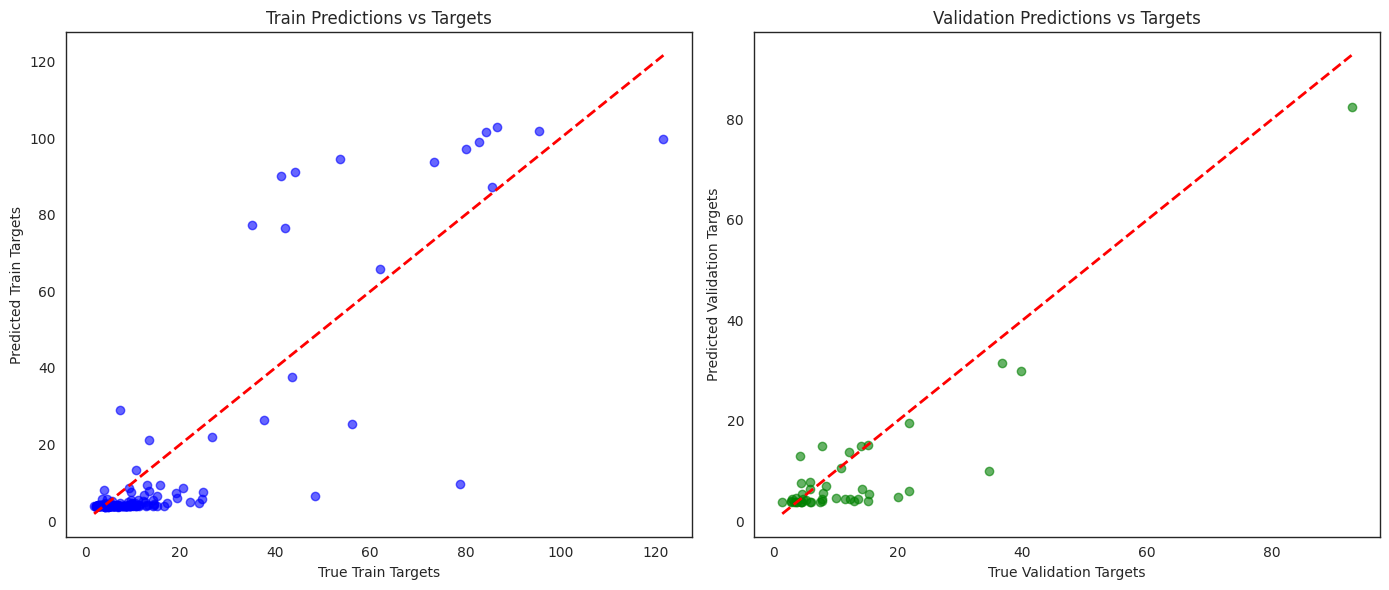

gat_v4_fc_act=['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu'] gat_num_layers=[2, 4, 6, 12] model_grid_search=['gat-v4'] use_gpu=True adj_thresh=0.9 lr=0.00036602507505241537 l1_lambda=3.2571440984377084e-05 dataset_name='ftd' precision='32-true' lr_scheduler='LambdaLR' gat={'num_layers': 2, 'hidden_channels': 256, 'heads': 4, 'v2': True} sync_batchnorm=False seed=49999 devices=[0, 1, 2, 3, 4, 5, 6, 7] lr_min=1e-06 modality='csf' batch_size=50 checkpoint_dir='/scratch/lcornelis/outputs/checkpoints' gat-v4={'hidden_channels': [32, 64], 'heads': [2, 2], 'use_layer_norm': True, 'which_layer': ['layer1', 'layer2', 'layer3', 'sex', 'mutation'], 'fc_dim': [256, 512, 512, 128], 'fc_dropout': 0.1, 'fc_act': 'relu', 'weight_initializer': 'truncated_normal', 'num_layers': None, 'channel_list': None, 'norm': None, 'plain_last': None} mutation_choices=[['GRN', 'MAPT', 'C9orf72', 'CTL']] gat_v4_weight_initializer=['xavier', 'kaiming', 'orthogonal', 'truncated_normal'] act_choices=['relu', 'tanh', '

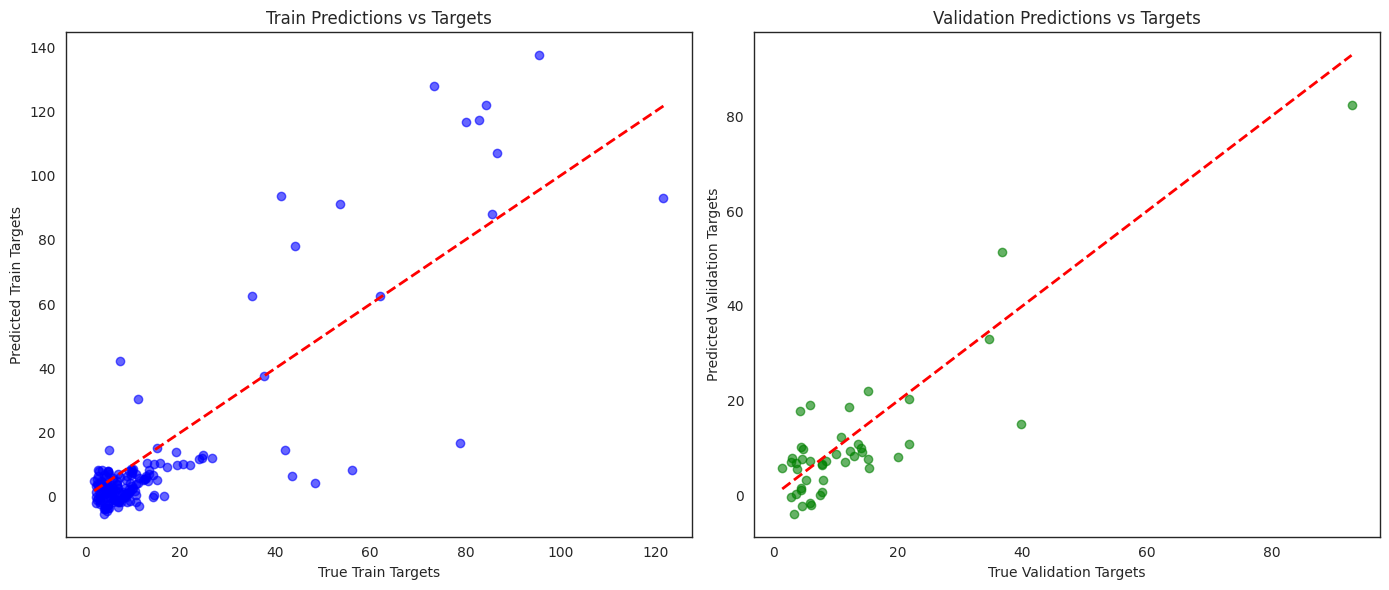

In [3]:
# Without Age:
# With Sex Specific Adj
model_1_no_age_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-04_18-54-36/model=gat-v4,seed=53034_1574_act=relu,adj_thresh=0.9000,batch_size=50,dropout=0.2000,l1_lambda=0.0000,lr=0.0013,lr_scheduler=Cosin_2024-11-05_15-31-35/checkpoint_000064"
model_2_no_age_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-04_18-54-36/model=gat-v4,seed=21407_2200_act=sigmoid,adj_thresh=0.9000,batch_size=16,dropout=0.1000,l1_lambda=0.0000,lr=0.0008,lr_scheduler=Co_2024-11-06_01-26-46/checkpoint_000237"
model_3_no_age_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-04_18-54-36/model=gat-v4,seed=49999_368_act=elu,adj_thresh=0.9000,batch_size=50,dropout=0.5000,l1_lambda=0.0000,lr=0.0004,lr_scheduler=LambdaL_2024-11-04_21-53-23/checkpoint_000107"
outputs = full_load_and_run_and_convert(model_1_no_age_sex, device, csf_all_no_log_mean, csf_all_no_log_std)
outputs = full_load_and_run_and_convert(model_2_no_age_sex, device, csf_all_no_log_mean, csf_all_no_log_std)
outputs = full_load_and_run_and_convert(model_3_no_age_sex, device, csf_all_no_log_mean, csf_all_no_log_std)

trainer_accelerator='gpu' act='tanh' wandb_tmp_dir='/tmp' q_gpu=True optimizer='Adam' gcn={'num_layers': 3, 'hidden_channels': 32} gat_v4_fc_dropout=[0.1, 0.2, 0.5] pin_memory=True y_val='nfl' act_choices=['relu', 'tanh', 'sigmoid', 'elu'] gat_heads=[1, 2, 4, 8] mlp={'channel_list': [7261, 32, 64, 128, 1], 'norm': 'batch_norm', 'plain_last': True} wandb_api_key_path='wandb_api_key.txt' num_nodes=7258 ray_results_dir='/scratch/lcornelis/outputs/ray_results' output_dir='/scratch/lcornelis/outputs' epochs=1000 nodes_count=1 lr=0.00028621014505834317 accumulate_grad_batches=1 grace_period=30 l1_lambda_min=1e-05 precision='32-true' model_grid_search=['gat-v4'] root_dir='/home/lcornelis/code/proteo' log_every_n_steps=10 checkpoint_dir='/scratch/lcornelis/outputs/checkpoints' raw_file_name='ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv' gat_v4_heads=[[2, 3], [2, 2], [4, 4]] modality='csf' devices=[0, 1, 2, 3, 4, 5, 6, 7] gat-v4={'hidden_channels': [8, 16], 'heads': [4, 4], 'use_layer

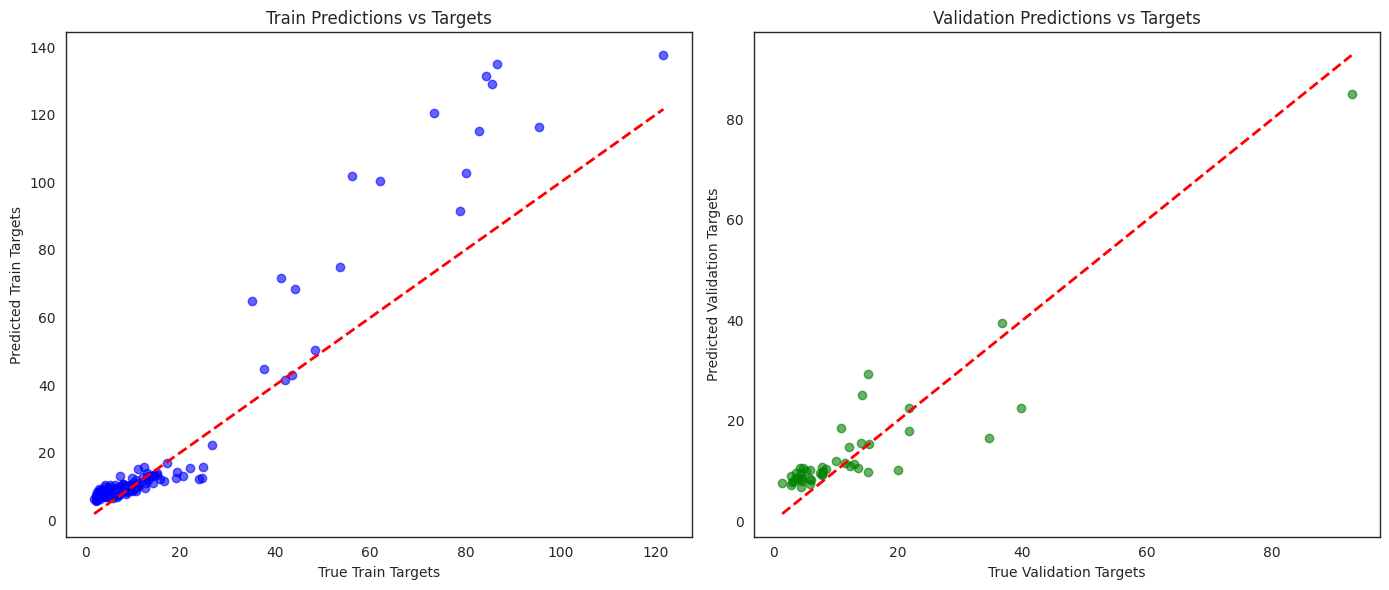

l1_lambda_min=1e-05 adj_thresh_choices=[0.2, 0.35, 0.5, 0.7, 0.9] gat_heads=[1, 2, 4, 8] batch_size_choices=[8, 16, 32, 50] weight_decay=0 ray_results_dir='/scratch/lcornelis/outputs/ray_results' act_choices=['relu', 'tanh', 'sigmoid', 'elu'] mutation_choices=[['GRN', 'MAPT', 'C9orf72', 'CTL']] q_gpu=True gat_num_layers=[2, 4, 6, 12] output_dir='/scratch/lcornelis/outputs' l1_lambda_max=0.1 l1_lambda=4.1308717106120854e-05 raw_file_name='ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv' adj_thresh=0.9 seed=47436 reduction_factor=6 sync_batchnorm=False mlp_plain_last=[True, False] num_workers=16 gat_v4_which_layer_choices=[['layer1', 'layer2', 'layer3', 'sex', 'mutation', 'age'], ['layer1', 'layer2', 'layer3', 'sex', 'mutation']] num_to_keep=2 act='tanh' gat_v4_heads=[[2, 3], [2, 2], [4, 4]] gat_v4_fc_dropout=[0.1, 0.2, 0.5] gcn_num_layers=[2, 3, 4] modality='csf' sex=['M', 'F'] use_progress_bar=True lr_scheduler_choices=['LambdaLR', 'ReduceLROnPlateau', 'StepLR', 'CosineAnnealing

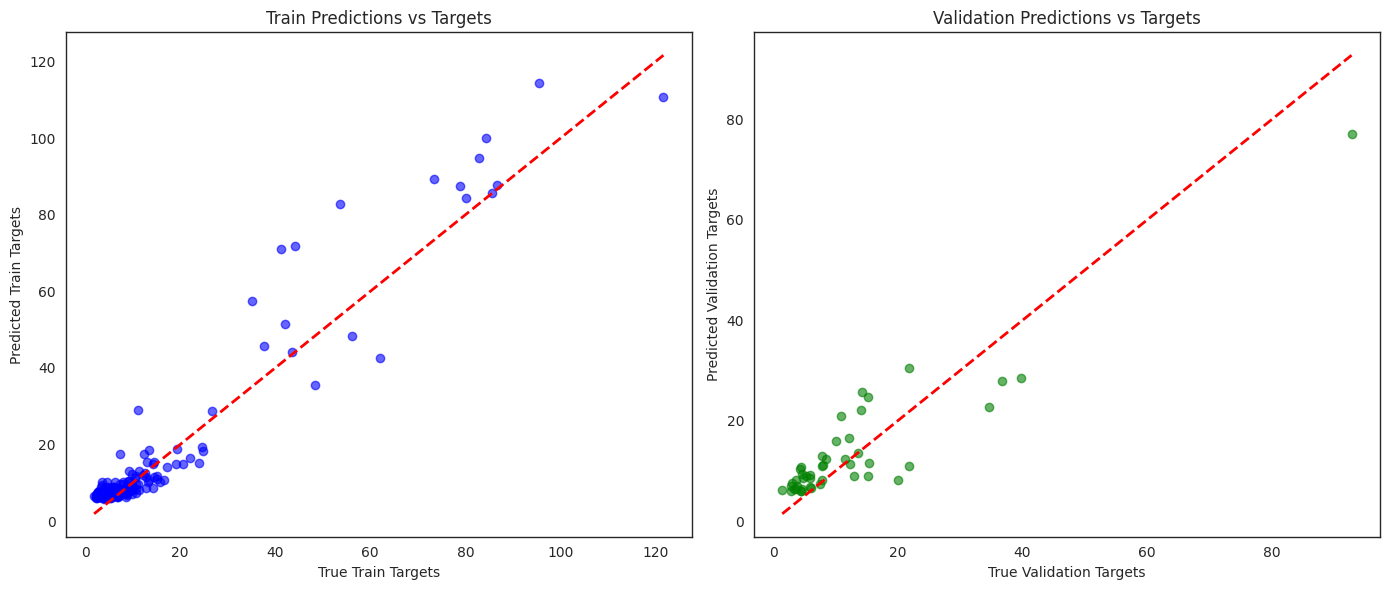

lr_max=0.1 lr_min=1e-06 mlp_channel_lists=[[7261, 1], [7261, 1028, 1], [7261, 128, 64, 1], [7261, 1028, 128, 1], [7261, 1028, 256, 64, 1], [7261, 1028, 512, 128, 1], [7261, 1028, 256, 128, 64, 1]] gcn_hidden_channels=[8, 32, 128] gat_hidden_channels=[8, 32, 128, 256] wgcna_mergeCutHeight=0.25 q_gpu=True y_val='nfl' nodes_count=1 accumulate_grad_batches=1 batch_size_choices=[8, 16, 32, 50] mlp_norms=['batch_norm', 'layer_norm'] num_nodes=7258 pin_memory=True mutation=['GRN', 'MAPT', 'C9orf72', 'CTL'] devices=[0, 1, 2, 3, 4, 5, 6, 7] epochs=1000 gat_heads=[1, 2, 4, 8] wgcna_minModuleSize=10 l1_lambda=3.503710154044107e-05 act_choices=['relu', 'tanh', 'sigmoid', 'elu'] data_dir='/scratch/lcornelis/data/data_louisa' gat_v4_fc_dim=[[64, 128, 128, 32], [128, 256, 256, 64], [256, 512, 512, 128]] lr_scheduler_choices=['LambdaLR', 'ReduceLROnPlateau', 'StepLR', 'CosineAnnealingLR'] act='tanh' gat_v4_heads=[[2, 3], [2, 2], [4, 4]] gat-v4={'hidden_channels': [8, 16], 'heads': [2, 2], 'use_layer_n

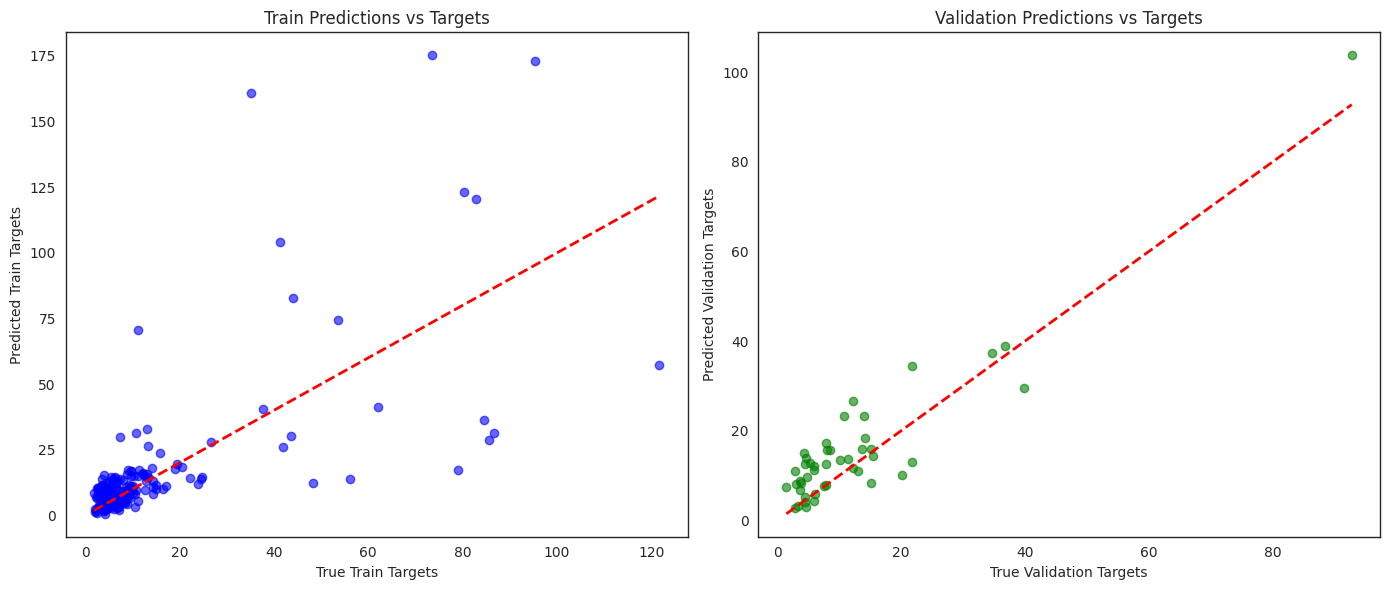

In [4]:
# With Age:
# Without Sex Specific Adj
model_1_age_no_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-10-29_13-49-44/model=gat-v4,seed=17318_2961_act=tanh,adj_thresh=0.7000,batch_size=50,dropout=0.5000,l1_lambda=0.0000,lr=0.0003,lr_scheduler=Cosin_2024-10-31_07-35-38/checkpoint_000150"
model_2_age_no_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-10-29_13-49-44/model=gat-v4,seed=47436_511_act=tanh,adj_thresh=0.9000,batch_size=8,dropout=0.1000,l1_lambda=0.0000,lr=0.0001,lr_scheduler=CosineA_2024-10-29_18-37-51/checkpoint_000342"
model_3_age_no_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-10-29_13-49-44/model=gat-v4,seed=51601_1917_act=tanh,adj_thresh=0.2000,batch_size=8,dropout=0.1000,l1_lambda=0.0000,lr=0.0006,lr_scheduler=Reduce_2024-10-30_16-39-16/checkpoint_000010"
outputs = full_load_and_run_and_convert(model_1_age_no_sex, device, csf_all_no_log_mean, csf_all_no_log_std)
outputs = full_load_and_run_and_convert(model_2_age_no_sex, device, csf_all_no_log_mean, csf_all_no_log_std)
outputs = full_load_and_run_and_convert(model_3_age_no_sex, device, csf_all_no_log_mean, csf_all_no_log_std)

In [1]:
# With Age:
# With Sex Specific Adj
model_1_age_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-10-29_13-49-44/model=gat-v4,seed=65438_2436_act=tanh,adj_thresh=0.7000,batch_size=16,dropout=0.5000,l1_lambda=0.0000,lr=0.0015,lr_scheduler=Lambd_2024-10-30_23-25-29/checkpoint_000069"
model_2_age_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-10-29_13-49-44/model=gat-v4,seed=48858_968_act=relu,adj_thresh=0.3500,batch_size=50,dropout=0.5000,l1_lambda=0.0003,lr=0.0028,lr_scheduler=Cosine_2024-10-30_03-03-38/checkpoint_000109"
model_3_age_sex = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-10-29_13-49-44/model=gat-v4,seed=65003_3748_act=sigmoid,adj_thresh=0.9000,batch_size=16,dropout=0.5000,l1_lambda=0.0002,lr=0.0002,lr_scheduler=La_2024-10-31_19-24-12/checkpoint_000027"
outputs = full_load_and_run_and_convert(model_1_age_sex, device, csf_all_no_log_mean, csf_all_no_log_std)
outputs = full_load_and_run_and_convert(model_2_age_sex, device, csf_all_no_log_mean, csf_all_no_log_std)
outputs = full_load_and_run_and_convert(model_3_age_sex, device, csf_all_no_log_mean, csf_all_no_log_std)

NameError: name 'full_load_and_run_and_convert' is not defined

act='elu' gat_v4_hidden_channels=[[8, 16], [32, 64], [64, 128]] num_workers=16 error_protein_file_name='bimodal_aptamers_for_removal.xlsx' batch_size=50 gat_v4_fc_dropout=[0.1, 0.2, 0.5] gat_hidden_channels=[8, 32, 128, 256] epochs=1000 mlp_plain_last=[True, False] master_nodes=['sex', 'mutation', 'age'] output_dir='/scratch/lcornelis/outputs' num_nodes_choices=[7258] sync_batchnorm=False dropout_choices=[0.1, 0.2, 0.5] gat_v4_weight_initializer=['xavier', 'kaiming', 'orthogonal', 'truncated_normal'] num_samples=2000 project='proteo' wgcna_mergeCutHeight=0.25 adj_thresh_choices=[0.2, 0.35, 0.5, 0.7, 0.9] l1_lambda_max=0.1 precision='32-true' wandb_tmp_dir='/scratch/lcornelis/tmp' seed=26212 pin_memory=True wgcna_minModuleSize=10 raw_file_name='ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv' root_dir='/home/lcornelis/code/proteo' gcn_hidden_channels=[8, 32, 128] act_choices=['relu', 'tanh', 'sigmoid', 'elu'] mutation_choices=[['GRN', 'MAPT', 'C9orf72', 'CTL']] use_progress_bar=T

torch.Size([50, 1])
torch.Size([1, 1])
Normalized Val MSE: tensor(0.2638, grad_fn=<MeanBackward0>)
Normalized Val MSE2: tensor(0.2638)
Normalized train MSE: 0.29195794463157654
Original Units Train MSE: tensor(3.7140)
Original Units Train RMSE: tensor(1.9272)
Original Units Val MSE: tensor(3.3559, grad_fn=<MseLossBackward0>)
Original Units Val RMSE: tensor(1.8319, grad_fn=<SqrtBackward0>)
Val Z scores: [-1.25321215e-02 -1.26232207e-02 -1.09607652e-02 -5.95603778e-04
 -1.23086134e-02 -1.19872717e-02  1.25809026e+00  6.48061261e-02
  4.32797700e-01 -7.71141425e-03  3.75499755e-01 -1.25515452e-02
  8.07757676e-03 -3.23184073e-01 -1.01382136e-02 -3.06578400e-03
 -9.97006427e-03 -1.03479314e+00  1.72315717e-01  9.87178013e-02
  1.17591560e+00  3.14868242e-02 -2.96396780e+00  4.78791334e-02
 -1.16281817e-02 -2.44634345e-01 -1.01242280e-02 -1.23507632e-02
 -1.16679311e-01  4.46770281e-01 -8.02770536e-03 -2.80403942e-01
 -1.27384709e-02 -1.19118402e-02 -6.77814428e-03  3.53933096e+00
 -1.18751

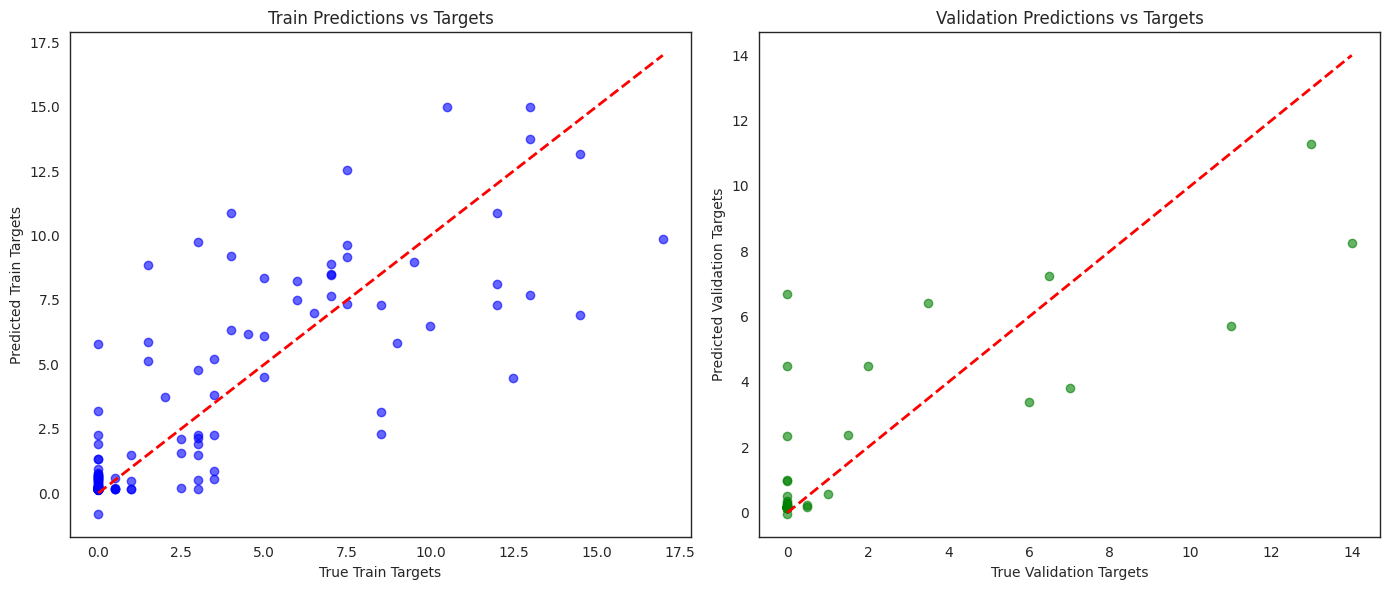

gcn={'num_layers': 3, 'hidden_channels': 32} dropout=0.5 l1_lambda=0.0015819476603248642 grace_period=30 y_val='clinical_dementia_rating' act='sigmoid' epochs=1000 gat_v4_fc_act=['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu'] root_dir='/home/lcornelis/code/proteo' ray_tmp_dir='/scratch/lcornelis/tmp' mutation=['GRN', 'MAPT', 'C9orf72', 'CTL'] batch_size=8 pin_memory=True data_dir='/scratch/lcornelis/data/data_louisa' num_samples=2000 dropout_choices=[0.1, 0.2, 0.5] gat_v4_fc_dropout=[0.1, 0.2, 0.5] sex_specific_adj_choices=[False] modality='csf' batch_size_choices=[8, 16, 32, 50] mlp_channel_lists=[[7261, 1], [7261, 1028, 1], [7261, 128, 64, 1], [7261, 1028, 128, 1], [7261, 1028, 256, 64, 1], [7261, 1028, 512, 128, 1], [7261, 1028, 256, 128, 64, 1]] num_to_keep=2 q_gpu=True accumulate_grad_batches=1 y_val_choices=['cog_z_score', 'clinical_dementia_rating'] gpu_per_worker=1 sex_specific_adj=False sex=['M', 'F'] gcn_hidden_channels=[8, 32, 128] modality_choices=['csf'] gat_v4_fc_dim=[[6

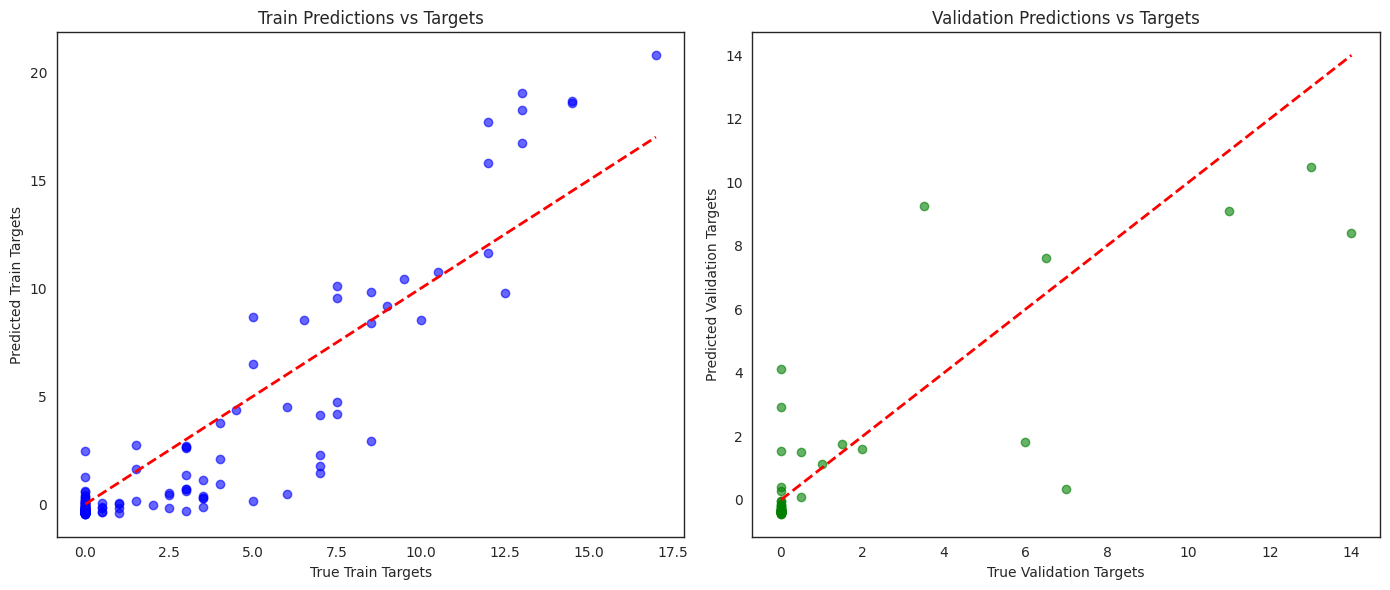

wgcna_minModuleSize=10 checkpoint_every_n_epochs_train=1 gat_v4_heads=[[2, 3], [2, 2], [4, 4]] mlp_channel_lists=[[7261, 1], [7261, 1028, 1], [7261, 128, 64, 1], [7261, 1028, 128, 1], [7261, 1028, 256, 64, 1], [7261, 1028, 512, 128, 1], [7261, 1028, 256, 128, 64, 1]] gat_v4_weight_initializer=['xavier', 'kaiming', 'orthogonal', 'truncated_normal'] gat-v4={'hidden_channels': [8, 16], 'heads': [4, 4], 'use_layer_norm': True, 'which_layer': ['layer1', 'layer2', 'layer3', 'sex', 'mutation', 'age'], 'fc_dim': [64, 128, 128, 32], 'fc_dropout': 0.1, 'fc_act': 'tanh', 'weight_initializer': 'truncated_normal', 'num_layers': None, 'channel_list': None, 'norm': None, 'plain_last': None} num_to_keep=2 sex=['M', 'F'] use_gpu=True dropout=0.5 lr_scheduler_choices=['LambdaLR', 'ReduceLROnPlateau', 'StepLR', 'CosineAnnealingLR'] grace_period=30 num_samples=2000 data_dir='/scratch/lcornelis/data/data_louisa' reduction_factor=6 epochs=1000 trainer_accelerator='gpu' lr_scheduler='LambdaLR' gat_num_layers

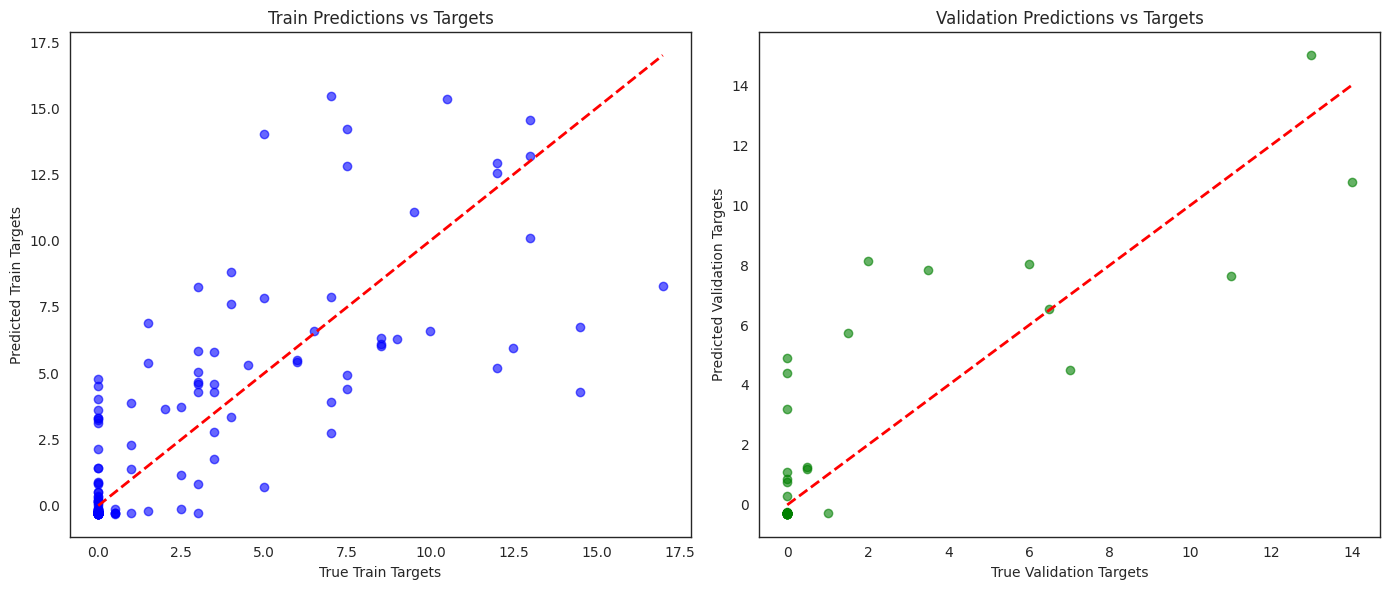

batch_size=8 l1_lambda_min=1e-05 master_nodes=['sex', 'mutation', 'age'] lr_max=0.1 sync_batchnorm=False root_dir='/home/lcornelis/code/proteo' grace_period=30 error_protein_file_name='bimodal_aptamers_for_removal.xlsx' num_workers=16 gpu_per_worker=1 lr_scheduler_choices=['LambdaLR', 'ReduceLROnPlateau', 'StepLR', 'CosineAnnealingLR'] lr_min=1e-06 checkpoint_dir='/scratch/lcornelis/outputs/checkpoints' y_val='clinical_dementia_rating' sex_specific_adj=False dropout=0.1 model='gat-v4' modality_choices=['csf'] wandb_tmp_dir='/scratch/lcornelis/tmp' checkpoint_every_n_epochs_train=1 precision='32-true' q_gpu=True epochs=1000 y_val_choices=['cog_z_score', 'clinical_dementia_rating'] trainer_accelerator='gpu' pin_memory=True gat-v4={'hidden_channels': [64, 128], 'heads': [2, 3], 'use_layer_norm': True, 'which_layer': ['layer1', 'layer2', 'layer3', 'sex', 'mutation', 'age'], 'fc_dim': [64, 128, 128, 32], 'fc_dropout': 0.1, 'fc_act': 'sigmoid', 'weight_initializer': 'truncated_normal', 'num_

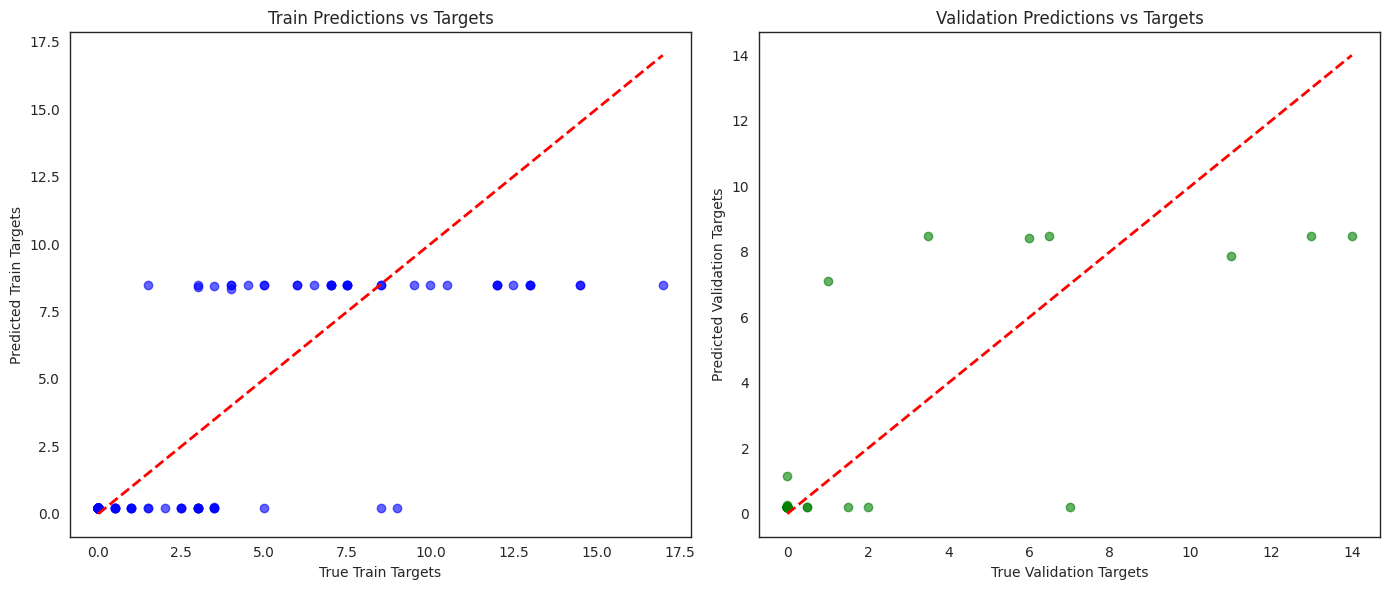

In [3]:
cdr_sb_all_mean = 1.812807881773399
cdr_sb_all_std = 3.5666674566521928
device = 'cpu'

cdr_model_1 = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-19_17-30-10/model=gat-v4,seed=26212_2169_act=elu,adj_thresh=0.7000,batch_size=50,dropout=0.2000,l1_lambda=0.0000,lr=0.0112,lr_scheduler=Lambda_2024-11-20_21-13-10/checkpoint_000165"
cdr_model_2 = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-19_17-30-10/model=gat-v4,seed=59322_2147_act=sigmoid,adj_thresh=0.3500,batch_size=8,dropout=0.5000,l1_lambda=0.0016,lr=0.0002,lr_scheduler=Cos_2024-11-20_21-04-43/checkpoint_000027"
cdr_model_3 = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-19_17-30-10/model=gat-v4,seed=2044_3039_act=elu,adj_thresh=0.7000,batch_size=50,dropout=0.5000,l1_lambda=0.0000,lr=0.0061,lr_scheduler=LambdaL_2024-11-21_09-04-19/checkpoint_000168"
cdr_model_7 = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-19_17-30-10/model=gat-v4,seed=54146_1741_act=sigmoid,adj_thresh=0.5000,batch_size=8,dropout=0.1000,l1_lambda=0.0000,lr=0.0012,lr_scheduler=Lam_2024-11-20_15-11-30/checkpoint_000179"
outputs = full_load_and_run_and_convert(cdr_model_1, device, cdr_sb_all_mean, cdr_sb_all_std)
outputs = full_load_and_run_and_convert(cdr_model_2, device, cdr_sb_all_mean, cdr_sb_all_std)
outputs = full_load_and_run_and_convert(cdr_model_3, device, cdr_sb_all_mean, cdr_sb_all_std)
outputs = full_load_and_run_and_convert(cdr_model_7, device, cdr_sb_all_mean, cdr_sb_all_std)


model_grid_search=['gat-v4'] gat_num_layers=[2, 4, 6, 12] q_gpu=True num_nodes_choices=[7258] wgcna_mergeCutHeight=0.25 wandb_api_key_path='wandb_api_key.txt' lr_max=0.1 mlp_plain_last=[True, False] gcn_num_layers=[2, 3, 4] modality='csf' grace_period=30 gat-v4={'hidden_channels': [32, 64], 'heads': [2, 2], 'use_layer_norm': True, 'which_layer': ['layer1', 'layer2', 'layer3', 'sex', 'mutation', 'age'], 'fc_dim': [128, 256, 256, 64], 'fc_dropout': 0.1, 'fc_act': 'tanh', 'weight_initializer': 'xavier', 'num_layers': None, 'channel_list': None, 'norm': None, 'plain_last': None} raw_file_name='ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv' pin_memory=True devices=[0, 1, 2, 3, 4, 5, 6, 7] master_nodes=['sex', 'mutation', 'age'] dropout=0.2 act='elu' precision='32-true' y_val_choices=['cog_z_score', 'clinical_dementia_rating'] optimizer='Adam' error_protein_file_name='bimodal_aptamers_for_removal.xlsx' sex=['M', 'F'] dropout_choices=[0.1, 0.2, 0.5] epochs=1000 adj_thresh_choices=[0.

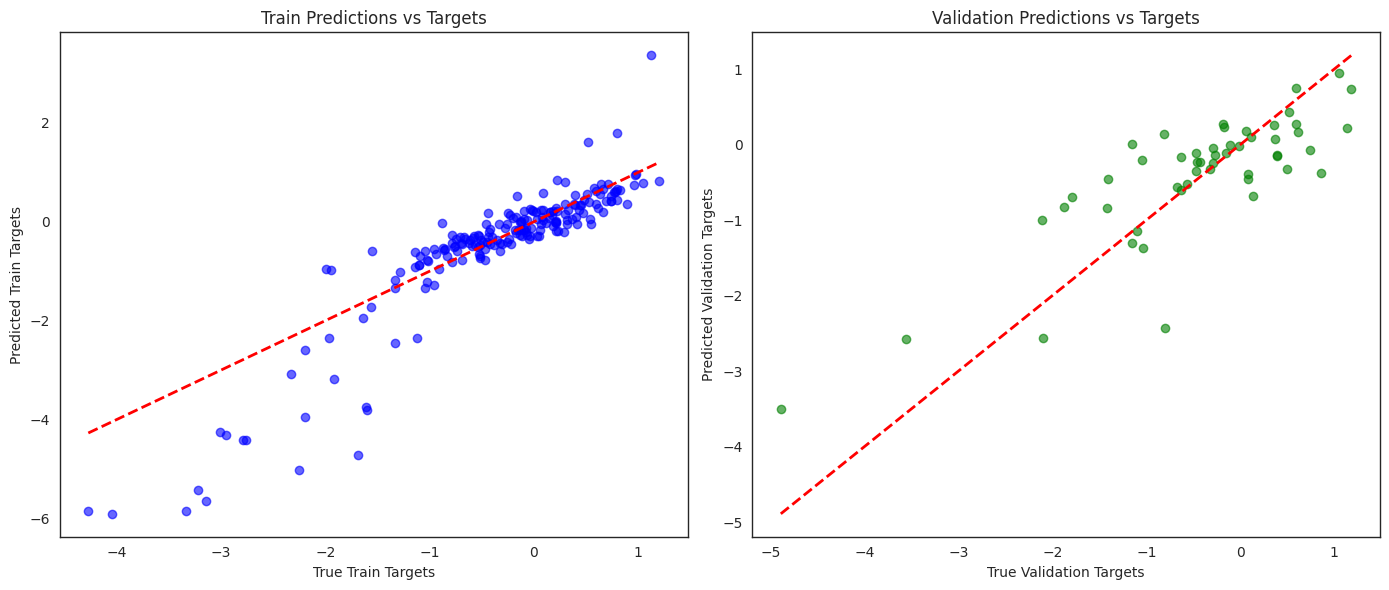

modality='csf' num_nodes_choices=[7258] cpu_per_worker=1 gat_v4_fc_dim=[[64, 128, 128, 32], [128, 256, 256, 64], [256, 512, 512, 128]] lr_scheduler='CosineAnnealingLR' use_gpu=True l1_lambda=0.00151751541986617 gat_v4_weight_initializer=['xavier', 'kaiming', 'orthogonal', 'truncated_normal'] use_master_nodes=False num_workers=16 accumulate_grad_batches=1 trainer_accelerator='gpu' l1_lambda_min=1e-05 num_to_keep=2 sex_choices=[['M', 'F']] optimizer='Adam' output_dir='/scratch/lcornelis/outputs' batch_size_choices=[8, 16, 32, 50] project='proteo' lr_min=1e-06 mlp={'channel_list': [7261, 32, 64, 128, 1], 'norm': 'batch_norm', 'plain_last': True} sync_batchnorm=False devices=[0, 1, 2, 3, 4, 5, 6, 7] use_progress_bar=True root_dir='/home/lcornelis/code/proteo' ray_tmp_dir='/scratch/lcornelis/tmp' mutation=['GRN', 'MAPT', 'C9orf72', 'CTL'] act_choices=['relu', 'tanh', 'sigmoid', 'elu'] wandb_api_key_path='wandb_api_key.txt' wgcna_minModuleSize=10 batch_size=8 sex_specific_adj_choices=[False]

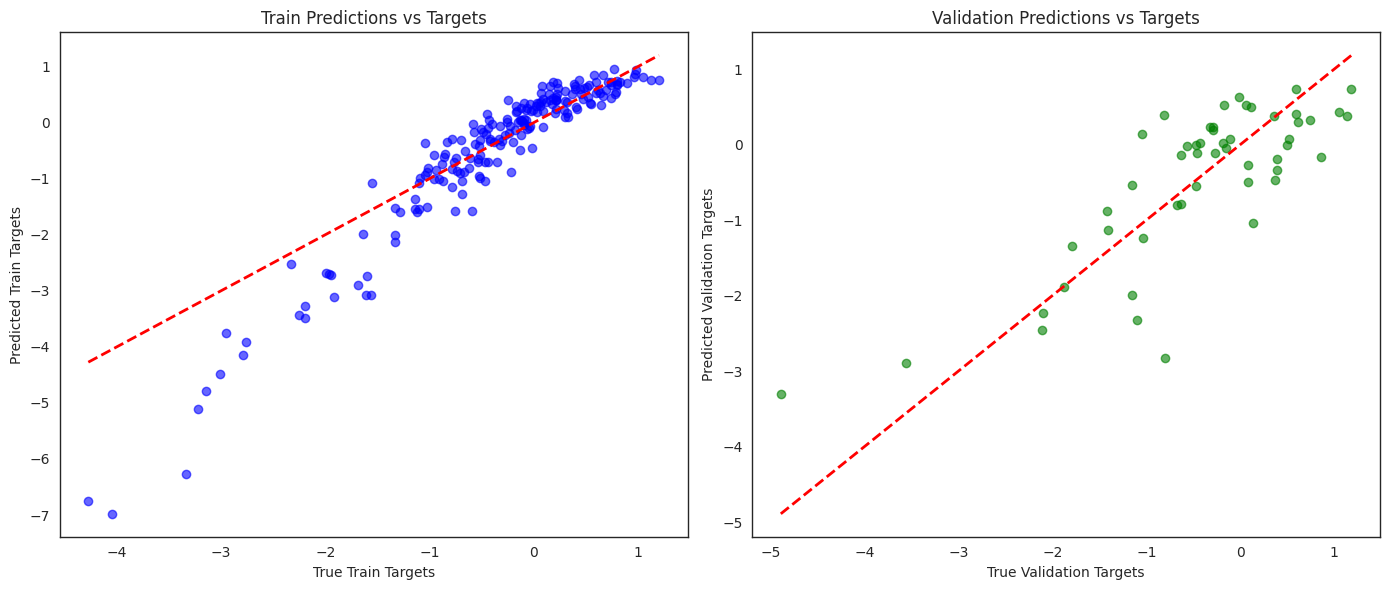

wandb_api_key_path='wandb_api_key.txt' wgcna_mergeCutHeight=0.25 gcn={'num_layers': 3, 'hidden_channels': 32} epochs=1000 act='sigmoid' wandb_offline=False dropout_choices=[0.1, 0.2, 0.5] gat_v4_heads=[[2, 3], [2, 2], [4, 4]] use_gpu=True dataset_name='ftd' y_val='cog_z_score' master_nodes=['sex', 'mutation', 'age'] batch_size_choices=[8, 16, 32, 50] optimizer='Adam' adj_thresh_choices=[0.2, 0.35, 0.5, 0.7, 0.9] mlp_plain_last=[True, False] gat={'num_layers': 2, 'hidden_channels': 256, 'heads': 4, 'v2': True} num_workers=16 use_progress_bar=True lr_scheduler_choices=['LambdaLR', 'ReduceLROnPlateau', 'StepLR', 'CosineAnnealingLR'] num_to_keep=2 act_choices=['relu', 'tanh', 'sigmoid', 'elu'] precision='32-true' gcn_hidden_channels=[8, 32, 128] gat_v4_fc_act=['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu'] modality_choices=['csf'] num_nodes_choices=[7258] gat_num_layers=[2, 4, 6, 12] sex_specific_adj_choices=[False] reduction_factor=6 trainer_accelerator='gpu' q_gpu=True batch_size=8 wand

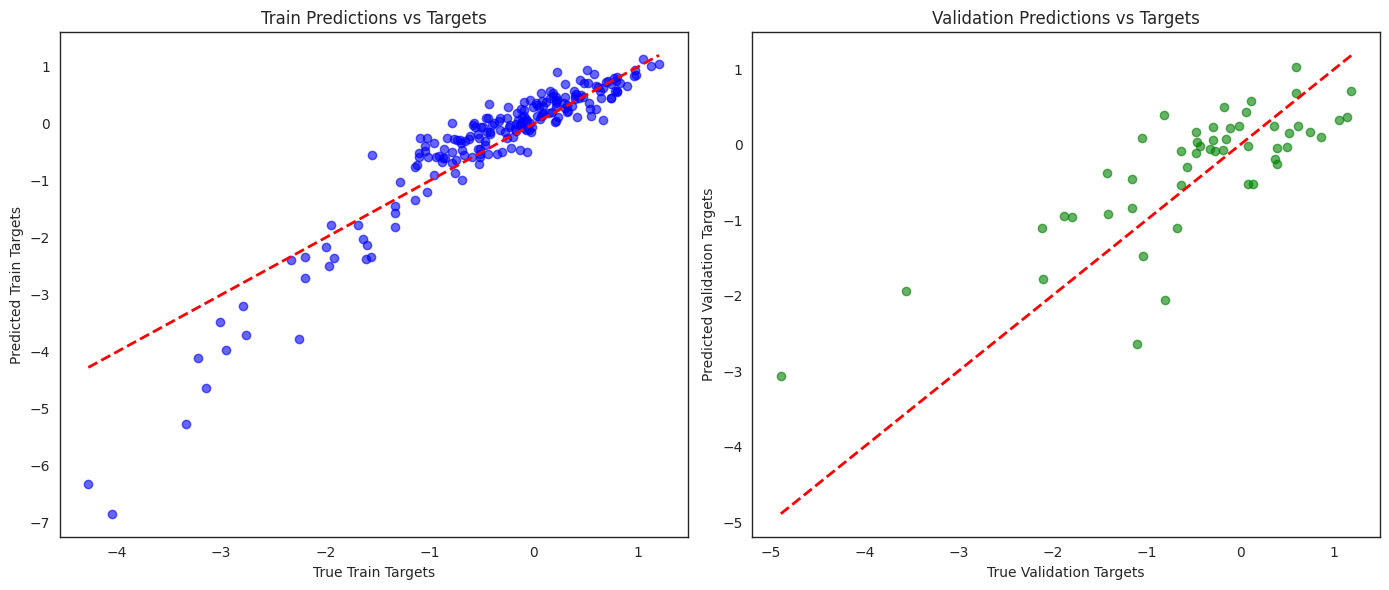

In [5]:
cog_z_all_mean = -0.41059763104455455
cog_z_all_std = 0.9939248987458366

cog_z_model_1 = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-19_17-30-10/model=gat-v4,seed=62026_1490_act=elu,adj_thresh=0.7000,batch_size=8,dropout=0.2000,l1_lambda=0.0004,lr=0.0001,lr_scheduler=CosineA_2024-11-20_11-06-37/checkpoint_000102"
cog_z_model_2 = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-19_17-30-10/model=gat-v4,seed=48777_3886_act=sigmoid,adj_thresh=0.7000,batch_size=8,dropout=0.2000,l1_lambda=0.0015,lr=0.0001,lr_scheduler=Cos_2024-11-21_23-31-41/checkpoint_000226"
cog_z_model_3 ="/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-11-19_17-30-10/model=gat-v4,seed=25221_1080_act=sigmoid,adj_thresh=0.5000,batch_size=8,dropout=0.5000,l1_lambda=0.0004,lr=0.0000,lr_scheduler=Cos_2024-11-20_03-56-26/checkpoint_000123"

outputs = full_load_and_run_and_convert(cog_z_model_1, device, cog_z_all_mean, cog_z_all_std)
outputs = full_load_and_run_and_convert(cog_z_model_2, device, cog_z_all_mean, cog_z_all_std)
outputs = full_load_and_run_and_convert(cog_z_model_3, device, cog_z_all_mean, cog_z_all_std)

In [24]:
module.validation_step(test_dataset.data)

RuntimeError: Given normalized_shape=[7258], expected input with shape [*, 7258], but got input of size[1, 326610]

In [ ]:
"/home/lcornelis/code/proteo/outputs/ray_results/TorchTrainer_2024-10-17_16-51-50/model=gat-v4,seed=1812_148_act=leaky_relu,adj_thresh=0.7000,batch_size=32,dropout=0.1000,l1_lambda=0.0000,lr=0.0044,lr_scheduler=L_2024-10-17_16-51-51/checkpoint_000094"
"/home/lcornelis/code/proteo/outputs/ray_results/TorchTrainer_2024-10-17_16-51-50/model=gat-v4,seed=1812_148_act=leaky_relu,adj_thresh=0.7000,batch_size=32,dropout=0.1000,l1_lambda=0.0000,lr=0.0044,lr_scheduler=L_2024-10-17_16-51-51/checkpoint_000094"

In [3]:
# Sex_specific_adj no sex
checkpoint1 = "/home/lcornelis/code/proteo/outputs/ray_results/TorchTrainer_2024-10-15_15-51-21/model=gat-v4,seed=15680_180_act=tanh,adj_thresh=0.3500,batch_size=32,dropout=0.1000,l1_lambda=0.0007,lr=0.0005,lr_scheduler=Lambda_2024-10-15_15-51-23/checkpoint_000001"
checkpoint2 = "/home/lcornelis/code/proteo/outputs/ray_results/TorchTrainer_2024-10-15_15-51-21/model=gat-v4,seed=60527_226_act=tanh,adj_thresh=0.9000,batch_size=32,dropout=0,l1_lambda=0.0025,lr=0.0006,lr_scheduler=LambdaLR,mo_2024-10-15_17-14-43/checkpoint_000006"
full_load_and_run_and_convert(checkpoint1 ,device, csf_all_mean, csf_all_std)

adj_thresh_choices=[0.1, 0.2, 0.35, 0.5, 0.7, 0.9] dropout=0.1 gat-v4={'hidden_channels': [8, 16], 'heads': [4, 4], 'use_layer_norm': True, 'which_layer': ['layer1', 'layer2', 'layer3', 'sex', 'mutation'], 'fc_dim': [128, 256, 256, 64], 'fc_dropout': 0.1, 'fc_act': 'relu', 'weight_initializer': 'orthogonal', 'num_layers': None} gat_hidden_channels=[8, 32, 128, 256] output_dir='/home/lcornelis/code/proteo/outputs' lr_min=1e-06 gcn_num_layers=[2, 3, 4] lr_scheduler='LambdaLR' nodes_count=1 raw_file_name='ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv' gpu_per_worker=1 gcn={'num_layers': 3, 'hidden_channels': 32} num_workers=16 trainer_accelerator='gpu' use_progress_bar=True gat_num_layers=[2, 4, 6, 12] modality_choices=['csf'] batch_size=32 seed=15680 lr_scheduler_choices=['LambdaLR', 'ReduceLROnPlateau', 'ExponentialLR', 'StepLR', 'CosineAnnealingLR'] gat_heads=[1, 2, 4, 8] reduction_factor=6 num_nodes=7258 lr=0.0005472969709054848 master_nodes=['sex', 'mutation', 'age'] epochs=

TypeError: expected 0 arguments, got 1

In [5]:
#Sanity check
def compute_manual_mse(val_preds, val_targets):
    """
    Manually computes the Mean Squared Error (MSE) for the given predictions and targets.

    Parameters:
    val_preds (list of list of torch.Tensor): The predicted values.
    val_targets (list of list of torch.Tensor): The true target values.

    Returns:
    float: The computed Mean Squared Error.
    """
   # Compute the squared differences
    squared_diffs = (val_preds - val_targets) ** 2

    # Compute the mean of the squared differences
    mse = squared_diffs.mean().item()

    return mse

print(compute_manual_mse(val_preds, val_targets))

0.2644430100917816


In [13]:
import os
import torch
import torch.nn.functional as F
import train as proteo_train

# Define a function to load the checkpoint and calculate MSE
def load_checkpoint_and_calculate_mse(relative_checkpoint_path, levels_up=5):
    # Get the current script directory
    current_directory = os.getcwd()
    
    # Navigate up the specified number of levels
    for _ in range(levels_up):
        current_directory = os.path.dirname(current_directory)
    
    # Construct the full path to the checkpoint
    checkpoint_path = os.path.join(current_directory, relative_checkpoint_path)
    print(f"Loading checkpoint from: {checkpoint_path}")

    # Check if the file exists to avoid errors
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    print("Checkpoint keys:", checkpoint.keys())
    print("checkpoint state_dict keys:", checkpoint['state_dict'].keys())

    module = proteo_train.Proteo.load_from_checkpoint(checkpoint_path)

    # Access the attributes
    # best_val_pred = module.best_val_pred
    # print("best_val_pred:", best_val_pred)
    # # print("min_val loss:", module.val_loss)
    # best_val_target = module.best_val_target
    # best_train_pred = module.best_train_pred
    # best_train_target = module.best_train_target

    # # Calculate MSE for validation and training
    # mse_val = F.mse_loss(best_val_pred, best_val_target).item()
    # mse_train = F.mse_loss(best_train_pred, best_train_target).item()

    return module, checkpoint

# Example usage
relative_checkpoint_path = '/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-07-31_16-47-02/model=gat-v4,seed=19543_0_act=relu,adj_thresh=0.1000,batch_size=8,dropout=0,l1_lambda=0.0000,lr=0.1000,lr_scheduler=LambdaLR,modal_2024-07-31_16-47-02/checkpoint_000001/checkpoint.cpkt'
module, checkpoint = load_checkpoint_and_calculate_mse(relative_checkpoint_path)
# print(f"MSE Loss for validation set: {mse_val}")
# print(f"MSE Loss for training set: {mse_train}")


Loading checkpoint from: /scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-07-31_15-31-35/model=gat-v4,seed=19543_0_act=relu,adj_thresh=0.1000,batch_size=8,dropout=0,l1_lambda=0.0000,lr=0.1000,lr_scheduler=LambdaLR,modal_2024-07-31_15-31-36/checkpoint_000001/checkpoint.ckpt
Checkpoint keys: dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])
checkpoint state_dict keys: odict_keys(['model.convs.0.att_src', 'model.convs.0.att_dst', 'model.convs.0.bias', 'model.convs.0.lin.weight', 'model.convs.1.att_src', 'model.convs.1.att_dst', 'model.convs.1.bias', 'model.convs.1.lin.weight', 'model.pools.0.weight', 'model.pools.0.bias', 'model.pools.1.weight', 'model.pools.1.bias', 'model.layer_norm.weight', 'model.layer_norm.bias', 'model.encoder.0.0.weight', 'model.encoder.0.0.bias', 'model.encoder.1.0.weight', 'model.encoder.1.0.bias', 'model.encoder.2.0.weight', 'model.